In [13]:
#importing packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.utils.data as data
import pandas as pd

In [14]:
#data transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

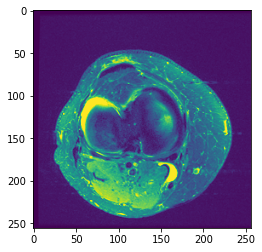

In [15]:
# Shi
# retrieve sample image
input_image = np.load("MRNet-v1.0/train/axial/0000.npy")
input_image.shape
plt.imshow(input_image[30])

from PIL import Image

im = Image.fromarray(input_image[1])
img = im.convert('RGB')
# img.show()

In [16]:
# Shi
# Transform image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)


In [17]:
# Shi
# load resnet18 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

Using cache found in /Users/chhunhong/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Shi
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([-2.2522e+00, -6.5522e-01,  1.9628e-01,  2.8600e+00,  3.6164e-01,
         2.7448e+00,  6.6952e-01, -2.3986e+00, -3.8303e+00, -6.7227e-01,
        -3.6155e+00, -4.5776e+00, -3.0640e+00, -4.8246e+00, -8.3617e-01,
        -3.6192e+00, -8.0123e+00, -2.8529e+00,  6.5950e-01, -3.2586e+00,
        -3.7077e+00, -8.2626e+00, -5.0531e+00, -5.1124e+00, -4.7201e+00,
         1.0792e+00, -1.1661e+00, -2.1520e+00,  2.5623e+00, -2.1108e+00,
         1.5578e+00,  3.6488e+00,  3.8153e+00,  1.6522e+00,  4.2716e-01,
        -1.2033e+00,  1.1237e+00, -4.0514e-01, -2.5158e-01, -3.0838e+00,
        -1.7823e+00, -3.9357e+00, -3.3397e+00, -4.1002e+00, -2.0601e+00,
        -2.3863e+00, -2.8950e+00, -5.0099e+00, -3.8962e+00, -2.1764e+00,
        -1.3137e+00,  2.8802e+00,  7.2483e-01,  2.4773e+00,  2.8460e+00,
        -9.5254e-01,  2.4130e+00, -9.2152e-01, -3.7418e-01,  2.0040e+00,
         5.7249e+00,  5.5664e+00,  1.9847e+00, -6.6522e-01, -8.8638e-01,
         3.7350e+00,  3.1616e+00,  1.3887e+00,  2.3

In [19]:
class MRDataset(data.Dataset):
    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])
        label = self.labels[index]
        label = torch.FloatTensor([label])

        if self.transform:
            array = self.transform(array)
        else:
            array = np.stack((array,)*3, axis=1)
            array = torch.FloatTensor(array)

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight

In [20]:
k = MRDataset('MRNet-v1.0/', 'acl', 'axial')

In [21]:
k.__getitem__(0)

(tensor([[[[ 0.,  0.,  0.,  ...,  5.,  4.,  3.],
           [ 0.,  0.,  0.,  ...,  8.,  6.,  8.],
           [ 0.,  0.,  0.,  ..., 14., 11., 11.],
           ...,
           [ 0.,  0.,  0.,  ..., 16., 15., 12.],
           [ 0.,  0.,  0.,  ..., 12., 13., 12.],
           [ 0.,  0.,  0.,  ..., 11.,  7.,  9.]],
 
          [[ 0.,  0.,  0.,  ...,  5.,  4.,  3.],
           [ 0.,  0.,  0.,  ...,  8.,  6.,  8.],
           [ 0.,  0.,  0.,  ..., 14., 11., 11.],
           ...,
           [ 0.,  0.,  0.,  ..., 16., 15., 12.],
           [ 0.,  0.,  0.,  ..., 12., 13., 12.],
           [ 0.,  0.,  0.,  ..., 11.,  7.,  9.]],
 
          [[ 0.,  0.,  0.,  ...,  5.,  4.,  3.],
           [ 0.,  0.,  0.,  ...,  8.,  6.,  8.],
           [ 0.,  0.,  0.,  ..., 14., 11., 11.],
           ...,
           [ 0.,  0.,  0.,  ..., 16., 15., 12.],
           [ 0.,  0.,  0.,  ..., 12., 13., 12.],
           [ 0.,  0.,  0.,  ..., 11.,  7.,  9.]]],
 
 
         [[[ 0.,  0.,  0.,  ...,  3.,  2.,  2.],
         